In [63]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math 

% matplotlib inline

In [31]:

# Import data files
data_folder = "/Users/vitou/Workspaces/AizawaLab/scientific_question_generation/data/clean/ai.stackexchange.com"
train_file = os.path.join(data_folder, "train.csv")
dev_file = os.path.join(data_folder, "dev.csv")
test_file = os.path.join(data_folder, "test.csv")

df_train = pd.read_csv(train_file)
df_dev = pd.read_csv(dev_file)
df_test = pd.read_csv(test_file)
df = pd.concat([df_train, df_dev, df_test])

save_dir = "/Users/vitou/Workspaces/AizawaLab/scientific_question_generation/analysis/figures/"
name = "ai.stackexchange.com"
save_dir = os.path.join(save_dir, name)

if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    print("Directory " , save_dir ,  " Created ") 

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64 entries, 0 to 6
Data columns (total 8 columns):
QuestionId       64 non-null int64
AnswerId         64 non-null int64
Title            64 non-null object
Tags             64 non-null object
QuestionBody     64 non-null object
QuestionScore    64 non-null int64
AnswerBody       64 non-null object
AnswerScore      64 non-null int64
dtypes: int64(4), object(4)
memory usage: 4.5+ KB


In [34]:
df['Title']

0              does this " flavor " of ai have a name ?
1                   problems in artificial intelligence
2                 memory intensive local search methods
3     predicting housing values with neural network ...
4     how to refine k - means clustering on a data s...
5     potential based reshaping : any potential func...
6         is robotic process automation related to ai ?
7     best way to build api for input data and get r...
8     why are deep neural networks and deep learning...
9                key point extraction the best method ?
10    what is the mapping between actions and number...
11    understanding the math behind using maximum li...
12    are the ideas in the paper " governance by gla...
13    reinforcement learning with adaptive action ma...
14      a sentence with different parse tree structures
15                                   sentiment analysis
16                q - learning tic tac toe - bad player
17    what makes multi - layer neural networks b

## Preparing the data

Read in the question and answer files.


In [52]:
def get_answer_length(row):
    a = row['AnswerBody']
    return len(a.split())

# answers.dropna(subset=['Body'], inplace=True)
df['AnswerLength'] = df.apply(get_answer_length, axis=1)

def get_title_length(row):
    a = row['Title']
    return len(a.split())
# questions.dropna(subset=['Title'], inplace=True)
df['TitleLength'] = df.apply(get_title_length, axis=1)

## Question Analysis
Count types of question in the dataset <br>
**WH-Question**: What, Who, Whom, Whose, Which, When, Where, Why, How <br>
**Aux-Question**: Do, Does, Did, Have, Has, Had, Is, Are, Was, Were

In [41]:
# WH-Question
wh_list = [
    'what', 
    'who', 
    'which', 
    'whom', 
    'where', 
    'when', 
    'whose', 
    'why', 
    'how'
]

# Do, Be, Has
yes_no_list = [
    'do',
    'does',
    'did',
    'have',
    'has',
    'had',
    'is',
    'are',
    'was',
    'were'
]

def count_question(titles):
    
    ''' Count each type of questions '''
    
    wh_count = 0
    yes_no_count = 0
    for title in titles:
        is_wh = False
        token = title.split()[0]

        if token in wh_list: 
            wh_count += 1
        elif token in yes_no_list:
            yes_no_count += 1
    return wh_count, yes_no_count

In [43]:
titles = df['Title']
wh_count, yes_no_count = count_question(titles)
total = len(titles)
normal = total - wh_count - yes_no_count

print ("WH-Question: {}".format(wh_count))
print ("Yes-No-Question: {}".format(yes_no_count))
print ("Total : {}".format(len(titles)))

WH-Question: 20
Yes-No-Question: 6
Total : 64


### Visualize the data into pie chart

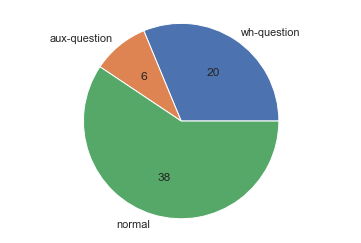

In [44]:
import seaborn as sns

sns.set(style="darkgrid")
fig1, ax1 = plt.subplots()

def absolute_value(val):
    a  = int(np.round(val/100.*total, 0))
    return a

sns.set()
sns.set_palette("Blues")

ax1.pie(
    [ wh_count, aux_count, normal], 
    labels=['wh-question', 'aux-question', 'normal'],
    autopct=absolute_value
)
ax1.axis('equal')
plt.show()
fig1.savefig(os.path.join(save_dir, 'question_type_chart.png'), dpi=300)

## Answer Analysis
- Basic analysis for the length of the answer
- Basic analysis with outlier removed
- Outlier is when the value exceeds 1.5 IQR from Q3
- Analysys the score of the answer

Understanding the answer's score before removing the outlier

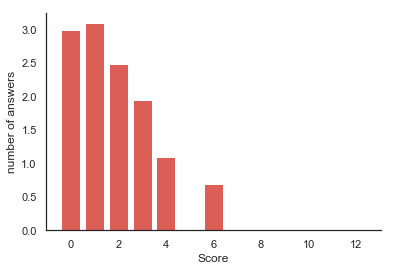

In [69]:
# Check how many answers per each score
num_answers = []
for i in range(13):
    a_score = df['AnswerScore'] == i
    num = a_score.sum()
    num_answers.append(num)
num_answers = [math.log(x+1) for x in num_answers]
# print ([math.log(x) for x in num_answers])
sns.set()
sns.set_style("white")
sns.set_palette("hls")
fig, ax = plt.subplots()
ax.bar(range(len(num_answers)), num_answers)
sns.despine()
ax.set_xlabel('Score')
ax.set_ylabel('number of answers')
plt.savefig(os.path.join(save_dir, 'hist_score.png'), dpi=300)

# print ("Number of Answer at Score: ")
# for i, v in enumerate(num_answers):
#     print ("Score {}: {}".format(i, v))

In [77]:
def get_arr_info(arr, column):
    
    """ Get info with graph about a column of DF """
    
    # Describe overview of data
    print ("Overview (num tokens):")
    print ("=========")
    print (arr.describe())
    
    # Box plot of the data
    sns.set()
    sns.set_style("whitegrid")
    sns.set_palette("BuGn_r", 1)
    plt.figure(figsize=(10,5))
    
    ax1= plt.subplot(1,2,1)
    sns.boxplot(None, arr)
    ax1.set_title(column + " length (all)")
    ax1.set_ylabel('number of tokens')
    
    ax2= plt.subplot(1,2,2)
    sns.boxplot(None, arr, showfliers=False)
    ax2.set_title(column + " length w/o upper outliers")
    ax2.set_ylabel('number of tokens')
    
    plt.suptitle(column + ' length')
    plt.savefig(os.path.join(save_dir, 'boxplot_answer_length.png'), dpi=300)
    plt.show() 
    
    # Display Distrubtion of the data
    
    num_bins = 20
#     arr = np.log(arr)
    
    sns.set()
    sns.set_style("white")
    sns.set_palette("hls")
    plt.figure(figsize=(15,5))
    
    ax4 = plt.subplot(1,2,1)
    ax4.hist(arr, bins=num_bins, alpha=1)
    sns.despine()
    ax4.set_xlabel("num of tokens")
    ax4.set_ylabel("num of " + column)
    
    Q1 = arr.quantile(.25)
    Q2 = arr.quantile(.5)
    Q3 = arr.quantile(.75)
    
    IQR = Q3 - Q1
    max_len = Q3 + IQR * 1.5
    
    ax5 = plt.subplot(1,2,2)
    ax5.hist(arr, bins=num_bins, range=(0, max_len), alpha=1)
    sns.despine()
    ax5.set_xlabel("num of tokens")
    ax5.set_ylabel("num of " + column)
    
    plt.suptitle("Distribution of Answer\'s token")
    plt.savefig(os.path.join(save_dir, 'dist_answer_token.png'), dpi=300)
    plt.show()
    

### Answer Analysis

Answer Length Analysis

Overview (num tokens):
count     64.000000
mean     218.562500
std      203.079692
min       31.000000
25%       66.000000
50%      144.000000
75%      309.000000
max      944.000000
Name: AnswerLength, dtype: float64


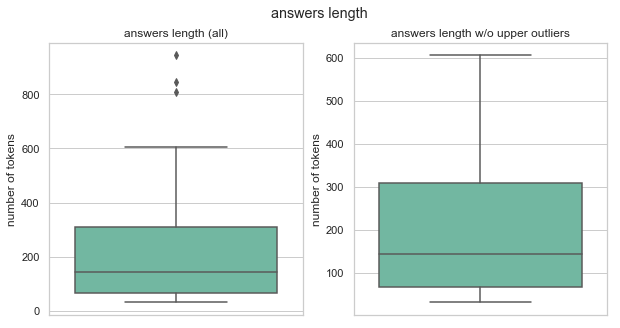

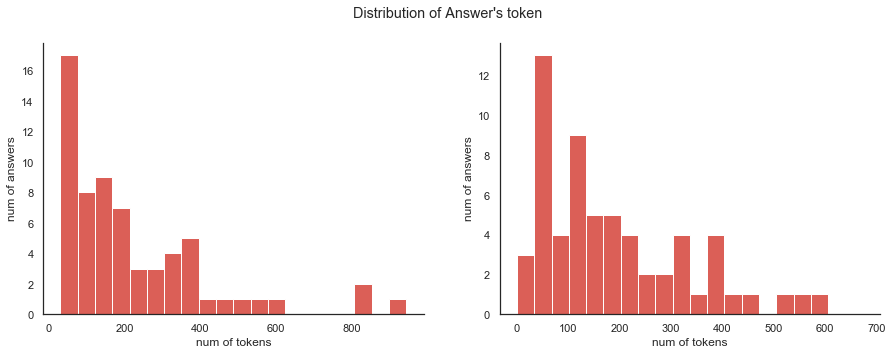

In [78]:
print ("Answer Length Analysis")
print ("======================\n")
get_arr_info(df['AnswerLength'], 'answers')

### Title Analysis

Title Length Analysis

Overview (num tokens):
count    64.000000
mean     10.875000
std       4.916768
min       2.000000
25%       7.000000
50%      10.000000
75%      14.000000
max      29.000000
Name: TitleLength, dtype: float64


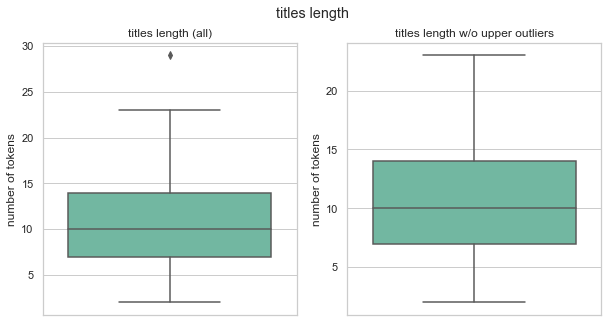

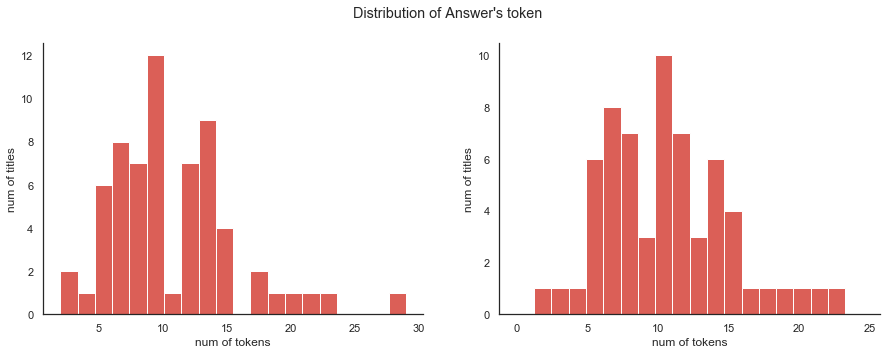

In [79]:
print ("Title Length Analysis")
print ("======================\n")
get_arr_info(df['TitleLength'], 'titles')

## Analysis of Tags
Analyze the tag used in the question when people are posting problem

In [80]:
tags_dict = {}
for tags in questions['Tags']:
    for t in tags.split():
        if t not in tags_dict:
            tags_dict[t] = 0
        tags_dict[t] += 1

NameError: name 'questions' is not defined

In [20]:
tags = sorted(tags_dict.items(), key=lambda x: x[1], reverse=True)

In [21]:
!pip install wordcloud

Vendor:  continuum
Product: anaconda
Message: trial mode expires in 26 days
  Retrying (Retry(total=4, connect=None, read=None, redirect=None)) after connection broken by 'NewConnectionError('<pip._vendor.requests.packages.urllib3.connection.VerifiedHTTPSConnection object at 0x105b8d590>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',)': /simple/wordcloud/
  Retrying (Retry(total=3, connect=None, read=None, redirect=None)) after connection broken by 'NewConnectionError('<pip._vendor.requests.packages.urllib3.connection.VerifiedHTTPSConnection object at 0x105b8d950>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',)': /simple/wordcloud/
  Retrying (Retry(total=2, connect=None, read=None, redirect=None)) after connection broken by 'NewConnectionError('<pip._vendor.requests.packages.urllib3.connection.VerifiedHTTPSConnection object at 0x105d07a10>: Failed to establish a new connection: [Errno 8] 

In [22]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create and generate a word cloud image:
wordcloud = WordCloud(width=1200, height=700, max_font_size=100, max_words=100, background_color="white")
wordcloud = wordcloud.generate_from_frequencies(tags_dict)

# Display the generated image:
plt.figure(figsize=(12,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('./wordcloud.png', dpi=600)
plt.show()



ImportError: No module named wordcloud

## Vocabulary Size

In [6]:
vocab = {}

# Get token from questions title
for titles in questions['Title']:
    for token in titles.split():
        if token not in vocab:
            vocab[token] = 0
        vocab[token] += 1
        
print ("num of vocabs in question: {}".format(len(vocab)))

# Get token from questions title
for body in answers['Body']:
    for token in body.split():
        if token not in vocab:
            vocab[token] = 0
        vocab[token] += 1
        
print ("num of vocabs: {}".format(len(vocab)))
        

num of vocabs in question: 4829
num of vocabs: 33588


In [8]:
vocab_arr = sorted(vocab.items(), key=lambda x: x[1], reverse=True)

In [20]:
import pickle
f = open("../outputs/ai.stackexchange.com/analysis.pickle", "rb")
pickle.load(f)

ValueError: unsupported pickle protocol: 3

In [18]:
file_dict

<open file '../outputs/ai.stackexchange.com/analysis.pickle', mode 'rb' at 0x10ab0b300>

In [ ]:
vocab_arr[:40]

In [ ]:
sns.boxplot(None, vocab.values()[1000:])

In [ ]:
words = sorted(vocab.values(), reverse=True)

In [ ]:

plt.plot(words[900:1000])

In [ ]:
df_words = pd.DataFrame(words)
df_words.describe()

In [ ]:
(df_words < 43).sum()

In [ ]:
(df_words < 10).sum()

In [ ]:
(df_words >= 43).sum()

In [ ]:
df_words[df_words < 43][40:60]

In [ ]:
(df_words < 1000).sum()

In [ ]:
vocab_arr[-500:]

In [ ]:
vocab_arr[50:100]

In [ ]:
df_words[5000:].hist(bins=30)

In [ ]:
df_words[5000:].plot()

In [ ]:
avg = df_words[:2000].mean().values[0]
df_words[:2000].plot(kind='line', ylim=(0,avg))

In [ ]:
avg = df_words.mean().values[0]
df_words.plot(kind='line', ylim=(0,avg))

In [ ]:
sorted(df_words.values())

In [ ]:
plt.plot(sorted(df_words.values))